# Step 4: Model Exploration and Optimization

In [1]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns

#image and output formatting
import PIL
from PIL import Image
from tabulate import tabulate

#dir manip libraries
import os, sys, glob, pathlib, tempfile
from pathlib import Path

#import label encoding
from sklearn.preprocessing import LabelEncoder

#keras for model output customization
import keras
from keras import layers, ops

#tensorflow tools for model building
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling, Activation, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


# Custom functions (this works, finally)
from pyTools.utils import *
from pyTools.preprocess import *
from pyTools.predict import *

# Print out versions for important tools
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Pillow version:", PIL.__version__)

Pandas version: 2.1.4
TensorFlow version: 2.16.1
Pillow version: 10.2.0


In [4]:
# Define the path to your Google Drive folder containing the images
data_dir = Path("../ML_Asm2_ProjFiles/classify_by_shape")

In [5]:
data = data_from_dir(data_dir)

Found 19860 files belonging to 5 classes.


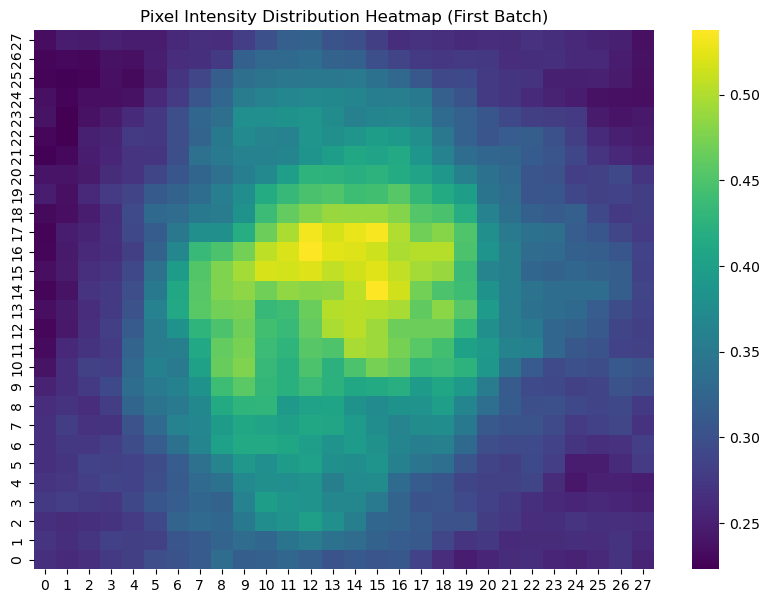

In [6]:
first_batch = next(iter(data))
images, labels = first_batch
images = images / 255.0
pixel_sum = np.zeros((img_height, img_width), dtype=float)

for img in images:
    pixel_sum += img.numpy().squeeze()  # .squeeze() to remove single-channel dimension
    
pixel_mean = pixel_sum / images.shape[0]
plt.figure(figsize=(10, 7))
sns.heatmap(pixel_mean, cmap='viridis')
plt.gca().invert_yaxis()  # This line reverses the y-axis direction
plt.title('Pixel Intensity Distribution Heatmap (First Batch)')
plt.show()

In [7]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [8]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

***compile()***:
  - ***optimizer***: Stochastic Gradient Descent, **Adoptive Moment Estimator(Adam)**
  - ***loss***: **Categorical (Focal) Cross Entropy**
  - ***metrics***: **(Categorical) Accuracy**, Top K Categorical, Categorical Cross Entropy, F1/Precision/Recall, AUC, IoU, MeanIoU

Initial design for baseline model.
Our goal was to design a simple Multilayer Perceptron baseline that utilizes keras libraries and utilities. Partially because of keras's versatility as a highly customisable tool, this model poses as a milestone for us to implement different modifications and tunings in development in the next steps.

In [9]:
external_dir = "../ML_Asm2_ProjFiles/Test"  # Path to your dataset
raw_data = []

# Loop through all image files in the specified directory
for img_file in os.listdir(external_dir):
    if img_file.endswith((".png", ".jpg", ".jpeg", ".bmp")):
        # Get the full path to the image
        img_path = os.path.join(external_dir, img_file)
        
        # Preprocess the image using the defined function
        preprocessed_img = preprocess28(img_path)
        
        # Add the preprocessed image to the raw_data list
        raw_data.append(preprocessed_img)

# Shuffle the images to randomize the order
random.shuffle(raw_data)

# Convert the list to a NumPy array
raw_data = np.array(raw_data)

# Notes: 
    Baseline model: 
     - Strength: 
     1. Classify data in the same dataset with very high accuracy. 
     2. Not computationally expensive
     
     - Weakness: 
     1. Inconsistent output metrics in each epoch. 
     2. Poor classification for external data
        -> Cause: Overfitting, Rudimentary Model. 

    Conclusion: Although the model did not perform well on external data, it reached a certain degree of generalization, which is fairly enough for this stage. 

In [10]:
model_1 = Sequential([ #Enhanced CNN, with no Batch Regularization and more Dense layers
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)), 
    Flatten(),
    Dense(1028, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model_2 = Sequential([ #CNN with Batch Normalization and less Dense layers
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_3 = Sequential([ #Deep Neural Network (notable design dif: (2 Conv layer -> Pooling)*3
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(218, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_4 = Sequential([ #CNN inspired from InceptionNet
    tf.keras.Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (1, 1), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (5, 5), activation='relu', padding='same'),
    MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model_5 = Sequential([ # 3 filter layer with incresing kernel size
    tf.keras.Input(shape=(28, 28, 1)),
    Conv2D(filters=32, kernel_size=(1, 1), activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(1, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])


NeuralNetwork_models = [model_1, model_2, model_3, model_4, model_5]

In [ ]:
# Iterate through each model
for target_model in NeuralNetwork_models:
    target_model.compile(
        optimizer=RMSprop(learning_rate=1e-4, momentum=0.9),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

    target_model.summary()

    hist = target_model.fit(
        train,
        epochs=25,
        batch_size=250,
        validation_data=val
    )

    # Plot the learning curve
    plot_learning_curve(hist)

    # Evaluate the model
    vResults_tf(target_model, val, data.class_names)
    vResults_raw(target_model, raw_data, data.class_names)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1028)                │       1,185,284 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1028)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         526,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,163,433 (8.25 MB)

 Trainable params: 2,163,433 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - loss: 1.4335 - sparse_categorical_accuracy: 0.3195 - val_loss: 0.4552 - val_sparse_categorical_accuracy: 0.8672
Epoch 2/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.3960 - sparse_categorical_accuracy: 0.8738 - val_loss: 0.1858 - val_sparse_categorical_accuracy: 0.9410
Epoch 3/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.2300 - sparse_categorical_accuracy: 0.9277 - val_loss: 0.1717 - val_sparse_categorical_accuracy: 0.9451
Epoch 4/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.9485 - val_loss: 0.1544 - val_sparse_categorical_accuracy: 0.9508
Epoch 5/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.9579 - val_loss: 0.1158 - val_sparse_categorical_accuracy: 0.9605
Epoch 6/25
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.9680